In [1]:
import sys,os
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
#from scipy.sparse import csr_matrix
#import Bio
import matplotlib.pyplot as plt

import inference_protein as vp

[[ 0  1  2  3]
 [ 4  5  6  7]
 [16 17 18 19]
 [20 21 22 23]]


In [2]:
# setting parameter:

np.random.seed(1)

n = 10 # number of positions
m = 3 # number of values at each position
l = 2000 # number of samples

(30, 30)


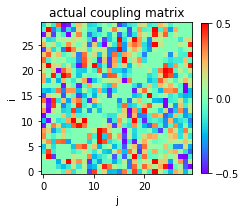

In [3]:
# generate coupling matrix w0:

g = 1.
nm = n*m
w0 = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
print(w0.shape)

# no self-interaction:
for i in range(n):
    i1 = i*m
    i2 = (i+1)*m 
    w0[i1:i2,i1:i2] = 0.

# symmetry interaction
for i in range(nm):
    for j in range(nm):
        if j > i: w0[i,j] = w0[j,i]

for i in range(n):
    i1 = i*m
    i2 = (i+1)*m 
    w0[i1:i2,:] = w0[i1:i2,:] - w0[i1:i2,:].sum(axis=0)            
            
plt.figure(figsize=(3,3))
plt.title('actual coupling matrix')
plt.imshow(w0,cmap='rainbow',origin='lower')
plt.xlabel('j')
plt.ylabel('i')
plt.clim(-0.5,0.5)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.5,0,0.5])
plt.show()

In [4]:
# initial s
s_ini = np.random.randint(0,m,size=(l,n))
print(s_ini)

# onehot encoder
enc = OneHotEncoder(n_values=m)
s = enc.fit_transform(s_ini).toarray()
print(s)

[[2 0 1 ... 2 2 0]
 [1 0 1 ... 2 2 0]
 [0 0 0 ... 2 1 1]
 ...
 [1 0 2 ... 2 1 2]
 [1 2 1 ... 2 1 0]
 [2 1 1 ... 0 1 1]]
[[0. 0. 1. ... 1. 0. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 ...
 [0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]]


In [5]:
# generate sequences:
def generate_sequences(w,n,m,l): 
        
    # initial s
    s_ini = np.random.randint(0,m,size=(l,n))
    #print(s_ini)
    
    # onehot encoder
    enc = OneHotEncoder(n_values=m)
    #s = csr_matrix(enc.fit_transform(s_ini)).toarray()
    s = enc.fit_transform(s_ini).toarray()
    #print(s)
    
    nflip = 100
    ntrial = 20
    for iflip in range(nflip):
        for i in range(n):
            i1 = i*m
            i2 = (i+1)*m   
            h = np.dot(s,w0.T)

            for t in range(l):                
                p1 = np.exp(h[t,i1:i2])
                #print(p1)
                p2 = p1.sum()
                p = p1/p2

                for itrial in range(ntrial):
                    k = np.random.randint(0,m)

                    if p[k] > np.random.rand():
                        s[t,i1:i2] = 0.
                        s[t,i1+k] = 1.

                        #print('flip',itrial,i,k,p[k])                  

                        break                         
    return s

#s = generate_sequences(w0,n,m,l)
#print(s)                

In [6]:
s0 = vp.generate_sequences(w0,n,m,l)

[2 1 0 0 2 0 2 2 1 0]
('after', -5.500827519436047)
('after', -3.0504878569218845)
('after', -5.393149279833605)
('after', -5.77920788357729)
('after', -5.839330888460119)
('after', -5.898477810394293)
('after', -5.939524392203496)
('after', -5.956172912633725)
('after', -5.883262574450274)
('after', -5.887249879476138)
[[2 2 2 2 2 0 1 0 0 2]
 [0 2 0 1 0 0 0 0 2 1]
 [2 2 2 1 2 1 1 2 1 2]
 [2 1 2 2 2 1 1 1 0 1]
 [2 1 0 2 2 1 1 1 1 0]
 [0 0 2 2 0 0 2 1 0 1]
 [2 1 0 2 0 0 0 2 2 0]
 [0 1 2 1 2 1 1 1 1 0]
 [2 2 0 2 0 0 2 0 2 0]
 [2 1 0 0 1 0 1 1 2 2]]


In [7]:
# onehot encoder
enc = OneHotEncoder(n_values=m)
s = enc.fit_transform(s0).toarray()

In [8]:
def inference():
    nloop = 5

    # w initial
    W = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
    # no self-interaction:
    for i in range(n):
        i1 = i*m
        i2 = (i+1)*m 
        W[i1:i2,i1:i2] = 0.

    H = np.dot(s,W.T)

    #print(H)
    #print(H.shape)

    # for i in range(n):
    i = 0
    i1 = i*m
    i2 = (i+1)*m

    # remove position i 
    s1 = np.hstack([s[:,:i1],s[:,i2:]])
    #print(s1)
    s_av = s1.mean(axis=0)
    ds = s1 - s_av

    c = np.cov(ds,rowvar=False,bias=True)
    c_inv = linalg.inv(c)
    dst = ds.T    

    h = H[:,i1:i2]

    for iloop in range(nloop):
        h_av = h.mean(axis=0)
        dh = h - h_av

        # dhds[t,i,j] = dh[t,i]*ds[t,j]
        dhds = dh[:,:,np.newaxis]*ds[:,np.newaxis,:]
        dhds_av = dhds.mean(axis=0)

        w = np.dot(dhds_av,c_inv)
        #print(w)

        w = w - w.sum(axis=0)

        h = np.dot(s1,w.T)
        p1 = np.exp(h)
        #print(p1)

        p2 = p1.sum(axis=1)
        #print(p2)

        p = p1/p2[:,np.newaxis]
        #print(p)

        h += s[:,i1:i2] - p
        cost = np.mean((s[:,i1:i2]-p)**2,axis=0)
        print(iloop,cost)   

    print(w)
    wpred = np.zeros((nm,nm))
    wpred[i1:i2,:i1] = w[:,:i1]
    wpred[i1:i2,i2:] = w[:,i1:]

    plt.scatter(w0[i1:i2,i2:],wpred[i1:i2,i2:])

[[2 2 2 ... 0 0 2]
 [0 2 0 ... 0 2 1]
 [2 2 2 ... 2 1 2]
 ...
 [2 1 2 ... 1 1 1]
 [0 0 0 ... 0 2 1]
 [0 0 0 ... 2 1 1]]


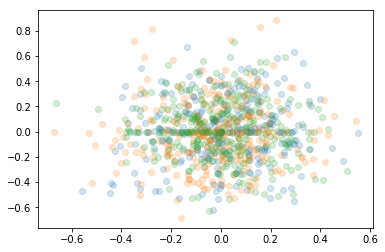

In [9]:
s_inv = np.argmax(s.reshape(-1,m),axis=1).reshape(-1,n)
print(s_inv)

w = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
b = np.zeros(nm)

for index in range(n):
    rang,disc = vp.iterate3(s_inv,w,b,index)
    w_tr_nonzero = np.abs(w0[:,index*n:(index+1)*n]) <1

    w_nonzero = np.abs(w[:,index*n:(index+1)*n]) <1

    w_true_nonzero = np.logical_and(w_tr_nonzero,w_nonzero)
    plt.plot((w[:,index*n:(index+1)*n])[w_true_nonzero],\
             (w0)[:,index*n:(index+1)*n][w_true_nonzero],'o',alpha = 0.2)
plt.show()
plt.close()    

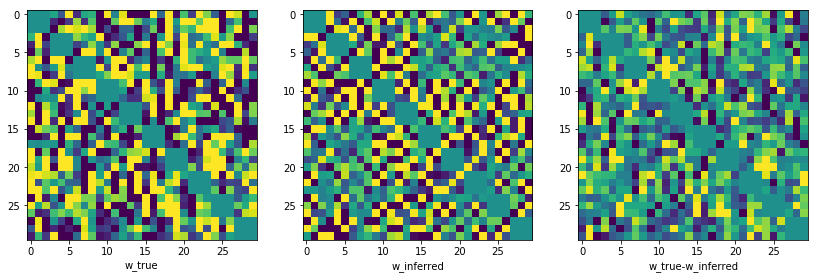

In [10]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3)
# make a little extra space between the subplots
fig.set_size_inches(14,44)
fig.subplots_adjust(hspace=0.5)

ax1.imshow(w0, vmin=-.2,vmax=0.2)
ax1.set_xlabel('w_true')

ax2.imshow(w,vmin=-.2,vmax=0.2)
ax2.set_xlabel('w_inferred')

ax3.imshow(w0-w,vmin=-.4,vmax=0.4)
ax3.set_xlabel('w_true-w_inferred')

plt.show()
plt.close()   